In [3]:
%matplotlib inline
%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import OrderedDict
import math
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import scipy.stats as stat

print("pandas version : ", pd.__version__)
print("xarray version : ", xr.__version__)
print("numpy version : ", np.__version__)

sns.set_style("whitegrid")
plt.rcParams["font.family"] = 'sans-serif'

('pandas version : ', u'0.23.4')
('xarray version : ', u'0.11.0')
('numpy version : ', '1.13.1')


### Analysis of residual reintroduced flow simulations
This notebook examine statistical moments (mean, variance) and correlation with observations computed with residual added simulations.

note:
vic streamflow is mm/day
mhm streamflow is m3/sec

In [4]:
# Getting Data: 
# 1. simulated streamflow from vic and mhm
# 2. Basin list file

data_path = './data'

# List of objective functions used
obj_fun_list = OrderedDict()
obj_fun_list['NSE'] = 'nse'
obj_fun_list['KGE'] = 'kge'
obj_fun_list['APFB'] = 'sig1'

# List of models used
model_list = ['vic', 'mhm']

# Read model ensemble simulated streamflow at daily steps
ds_vic_flow_ens_all = xr.open_dataset('%s/results_hcdn_flow_vic_491_ens.nc'%data_path)
ds_mhm_flow_ens_all = xr.open_dataset('%s/results_hcdn_flow_mhm_491_ens.nc'%data_path)

# Read model deterministic simulated streamflow at daily steps
ds_vic_flow_all = xr.open_dataset('%s/results_hcdn_flow_vic_491.nc'%data_path)
ds_mhm_flow_all = xr.open_dataset('%s/results_hcdn_flow_mhm_491.nc'%data_path)

# Read basin attributes 
df_hcdn = pd.read_csv('%s/hcdn.calib.conus.491.list'%data_path, delim_whitespace=True,
                   header=None, names=['id', 'lat', 'lon', 'area'])    #area is sq-meters

nbasin = len(df_hcdn['id'])
ndata = len(obj_fun_list)
nmodel = len(model_list)
nens = len(ds_vic_flow_ens_all['ens'])

# Print data variables
print('VIC flow data')
print('-------------')
print(ds_vic_flow_ens_all)
print('\nmHM flow data')
print('-------------')
print(ds_mhm_flow_ens_all)
print('\nhcdn list')
print(df_hcdn['id'].values)

VIC flow data
-------------
<xarray.Dataset>
Dimensions:  (ens: 100, hcdn: 491, time: 6940)
Coordinates:
  * hcdn     (hcdn) int32 1022500 1031500 1047000 ... 14325000 14362250 14400000
  * time     (time) datetime64[ns] 1989-10-01 1989-10-02 ... 2008-09-30
  * ens      (ens) int32 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
Data variables:
    nse_ens  (hcdn, time, ens) float32 ...
    kge_ens  (hcdn, time, ens) float32 ...
    obs      (hcdn, time) float32 ...
Attributes:
    history:                    Sun Dec 23 07:11:18 2018: ncks -A -v obs resu...
    history_of_appended_files:  Sun Dec 23 07:11:18 2018: Appended file resul...
    NCO:                        netCDF Operators version 4.7.4 (http://nco.sf...

mHM flow data
-------------
<xarray.Dataset>
Dimensions:  (ens: 100, hcdn: 491, time: 6940)
Coordinates:
  * hcdn     (hcdn) int32 1022500 1031500 1047000 ... 14325000 14362250 14400000
  * time     (time) datetime64[ns] 1989-10-01 1989-10-02 ... 2008-09-30
  * ens  

In [5]:
# Personal functions used here.
def nse(qsim, qobs):
    return 1-np.sum((qsim-qobs)**2)/np.sum((qobs-np.mean(qobs))**2)
  
def corr(qsim, qobs):
    return np.corrcoef(qsim, qobs)[0, 1]
       
def alpha(qsim, qobs):
    return math.sqrt(np.sum((qsim-np.mean(qsim))**2)/len(qsim))/math.sqrt(np.sum((qobs-np.mean(qobs))**2)/len(qobs))
    
def beta(qsim, qobs):
    return np.mean(qsim)/np.mean(qobs)

def kge(qsim, qobs):
    return 1-math.sqrt((1-corr(qsim, qobs))**2 + (alpha(qsim, qobs)-1)**2 + (beta(qsim, qobs)-1)**2)

def pbias(qsim, qobs):
    return np.sum((qsim-qobs))/np.sum(qobs)

In [6]:
# Analysis basin
hcdn = 1022500

<IPython.core.display.Javascript object>


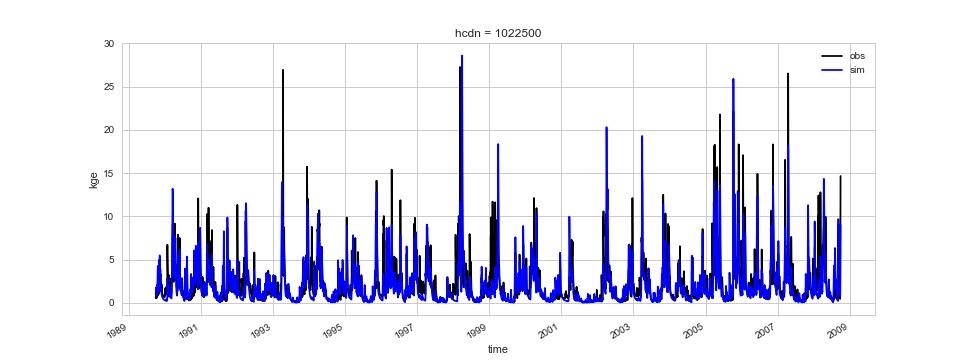

<IPython.core.display.Javascript object>


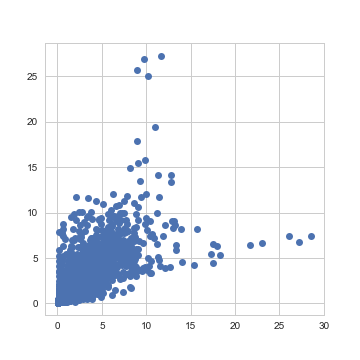

In [7]:
#plot time series of obs and calibrated flow
_, ax = plt.subplots(figsize=(13.5, 5.0))
ds_vic_flow_all['obs'].sel(hcdn=hcdn).plot(ax = ax, color='black',label='obs')
ds_vic_flow_all['kge'].sel(hcdn=hcdn).plot(ax = ax, color='blue',label='sim')
ax.legend()

#plot scatter plots between obs and sim
_, ax1 = plt.subplots(figsize=(5, 5))
ax1.plot(ds_vic_flow_all['kge'].sel(hcdn=hcdn)[0:365*10],ds_vic_flow_all['obs'].sel(hcdn=hcdn)[0:365*10], 'o')

<IPython.core.display.Javascript object>


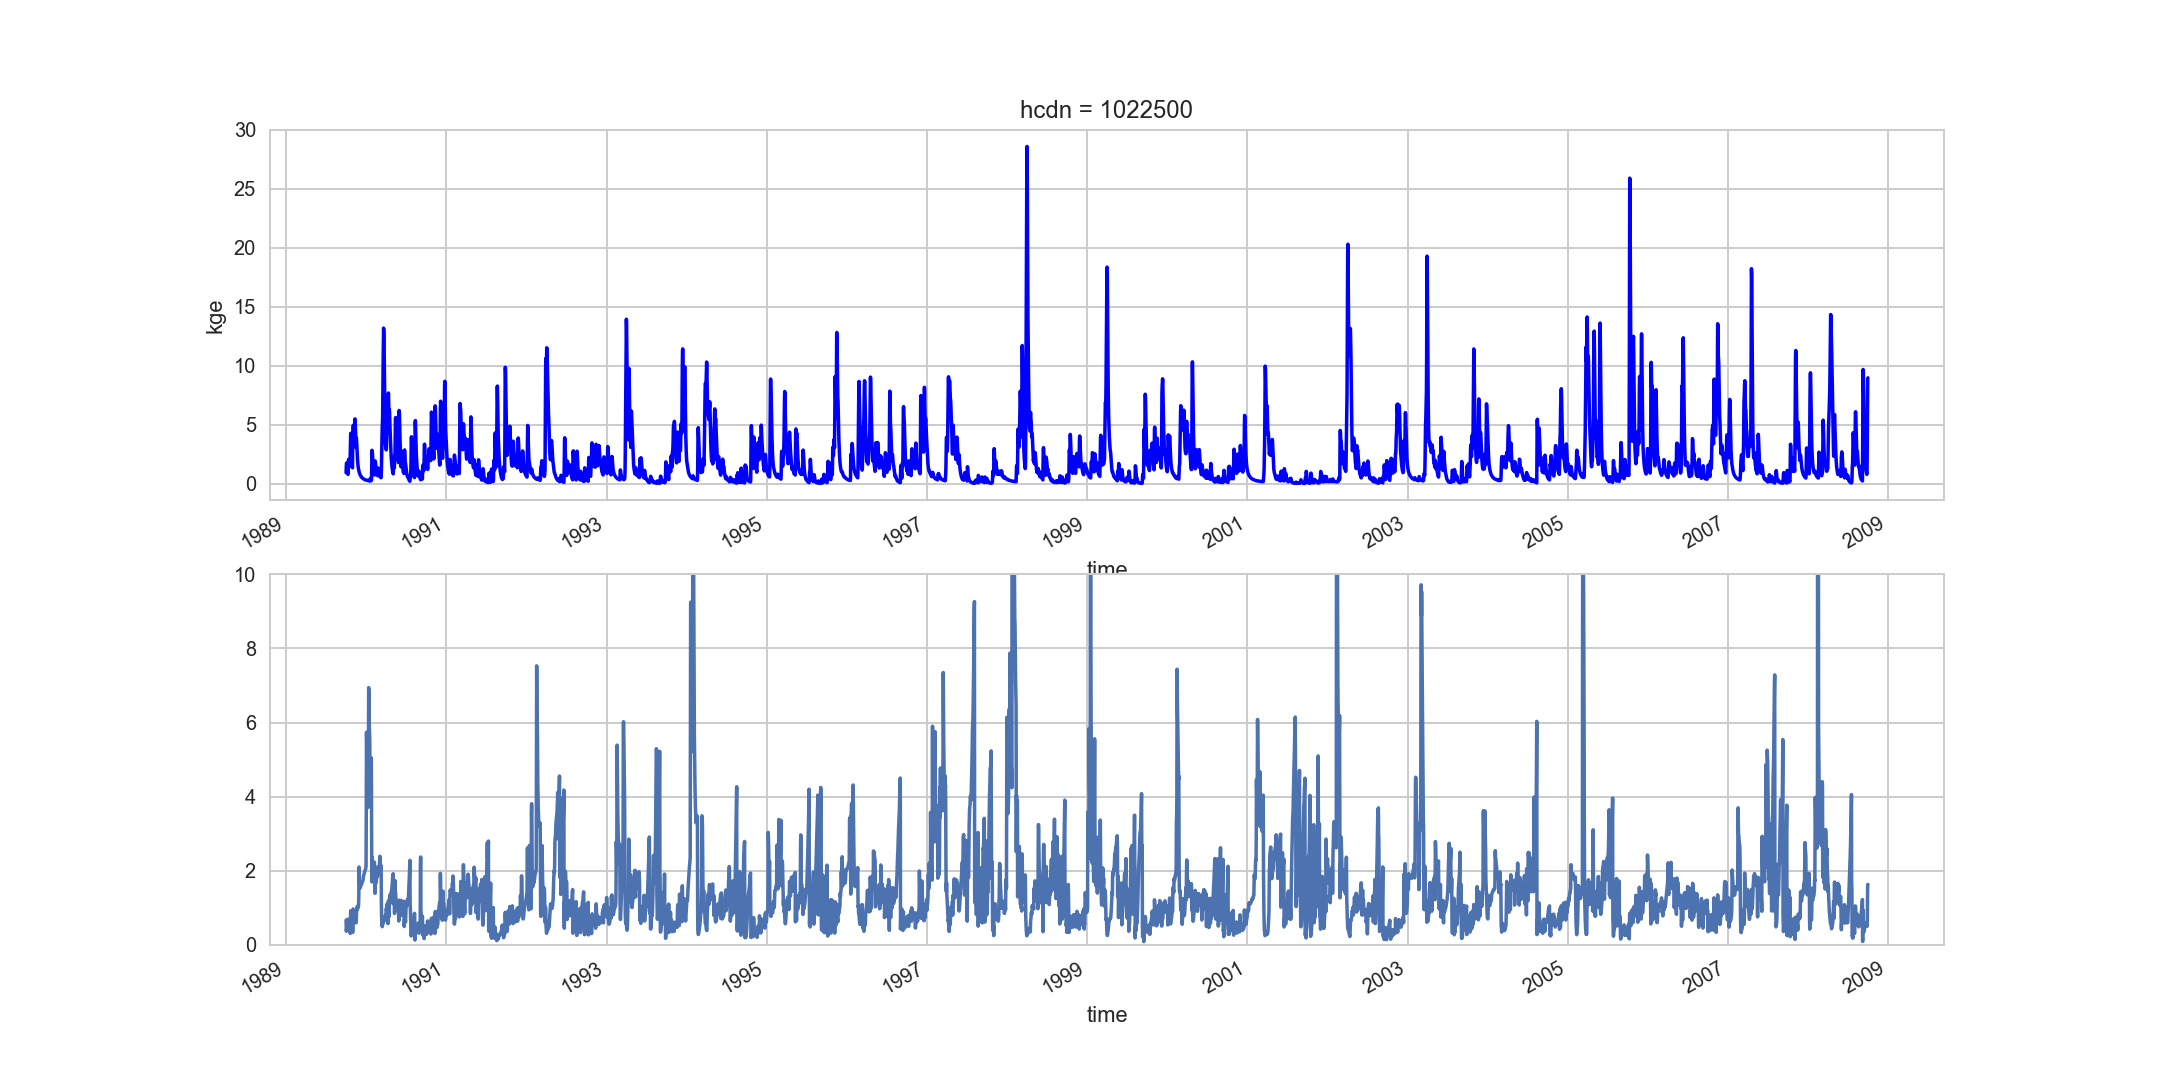

Text(0.5,1,'')

In [18]:
obs = ds_vic_flow_all['obs']
sim_kge = ds_vic_flow_all['kge']
sim_nse = ds_vic_flow_all['nse']

sim_kge = sim_kge.where(sim_kge>0.0, 1.0e-7)
sim_nse = sim_nse.where(sim_nse>0.0, 1.0e-7)
obs = obs.where(obs>0.0, 1.0e-7)

res_kge = obs/sim_kge
res_nse = obs/sim_nse

_, ax = plt.subplots(2,1, figsize=(15, 7.5))
obs.sel(hcdn=hcdn).plot(ax=ax1[0], color='black')
sim_kge.sel(hcdn=hcdn).plot(ax=ax[0], color='blue')
res_kge.sel(hcdn=hcdn).plot(ax=ax[1])
ax[1].set_ylim(0, 10)
ax[1].set_title('')

<IPython.core.display.Javascript object>


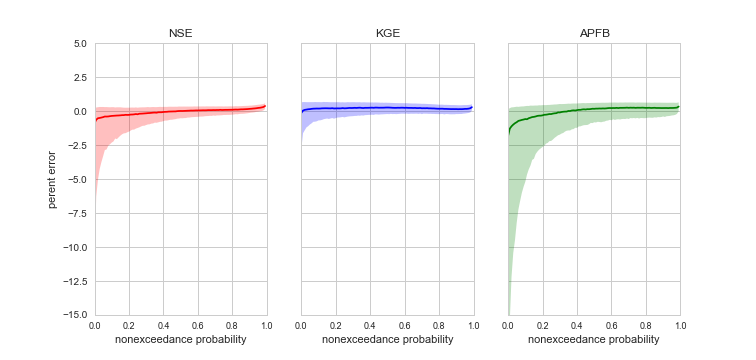

('NSE', 'nse')
('KGE', 'kge')
('APFB', 'sig1')


In [14]:
model = 'mhm'
clr=['r','b','g']
lstyle ='-'

if model == 'vic':
    ds_flow_all = ds_vic_flow_all
elif model == 'mhm':
    ds_flow_all = ds_mhm_flow_all
ds_flow_val = ds_flow_all.sel(time=slice('1989-10-01', '1999-09-30'))
ds_flow_cal = ds_flow_all.sel(time=slice('1999-10-01', '2008-09-30'))

ntime_cal = len(ds_flow_cal['time'])
ntime_val = len(ds_flow_val['time'])
ntime_all = len(ds_flow_all['time'])

_, ax = plt.subplots(1,len(obj_fun_list),figsize=(10.5, 5))

for kdx, (obj_key, obj_val) in enumerate(obj_fun_list.items()):
    print(obj_key, obj_val)
    prange = np.arange(0.,1.01,0.01)
    res25 = np.full(len(prange)-1, -999.0)
    res50 = np.full(len(prange)-1, -999.0)
    res75 = np.full(len(prange)-1, -999.0)

    # initialize
    res_prange = {}
    for jdx in range(len(prange)-1):
        res_prange[jdx] = []

    for idx, hid in enumerate(df_hcdn['id'].values):
        obs = ds_flow_val['obs'].sel(hcdn=hid).values
        sim = ds_flow_val[obj_val].sel(hcdn=hid).values
        ntime = ntime_val

        sim = np.where(sim>0.0, sim, 1.0e-7)
        obs = np.where(obs>0.0, obs, 1.0e-7)

        res = (obs-sim)/obs
        obs_sort = np.sort(obs)
        index_ordered = np.argsort(obs)
        res_ordered = res[index_ordered]

        prob=np.arange(1,float(len(res)+1))/(1+len(res)) #probability

        for jdx in range(len(prange)-1):
            res_prange[jdx].append(res_ordered[(prob >= prange[jdx]) & (prob < prange[jdx+1])])

    for jdx in range(len(prange)-1):
        res25[jdx] = np.percentile(np.asarray(res_prange[jdx]), 25) 
        res50[jdx] = np.percentile(np.asarray(res_prange[jdx]), 50)
        res75[jdx] = np.percentile(np.asarray(res_prange[jdx]), 75) 

    ax[kdx].plot(prange[:-1], res50, color=clr[kdx], ls=lstyle, label=ob)
    ax[kdx].fill_between(prange[:-1], res75, res25, facecolor=clr[kdx], alpha=0.25, label=obj_key)
    ax[kdx].set_title(obj_key)
    ax[kdx].set_xlabel('nonexceedance probability')
    if kdx == 0:
        ax[kdx].set_ylabel('perent error')
    if kdx > 0:
        ax[kdx].set_yticklabels('')
    ax[kdx].grid(True)
    ax[kdx].set_xticks(np.arange(0.,1.01,0.20))
    ax[kdx].set_xlim(0, 1.0)
    ax[kdx].set_ylim(-15, 5)
    ax[kdx].xaxis.set_tick_params(labelsize=9)
    plt.savefig('../../Paper5_ffa/revision1/figure/flow_residual.%s.pdf' % (model),
            format='pdf', 
            dpi=300, 
#           bbox_extra_artists=(lgd,), 
            bbox_inches='tight')

In [21]:
# residual and statistical moment
sim=ds_mhm_flow_all['kge'].sel(hcdn=hcdn)
obs=ds_mhm_flow_all['obs'].sel(hcdn=hcdn)
res = obs-sim

# Mean
obs_mean = obs.mean()
sim_mean = sim.mean()
res_mean = res.mean()
print('Mean')
print('obs, sim, residual')
print('%f %f %f'%(obs_mean, sim_mean, res_mean))

# Variance
obs_var = obs.var()
sim_var = sim.var()
res_var = res.var()
sim_res_cov = np.cov(sim.values, res.values)[0][1]
print('\nvariance')
print('obs, sim, residual, 2 x covariance between sim and res')
print('%f %f %f %f'%(obs_var, sim_var, res_var, 2*sim_res_cov))

# Covariance
obs_sim_cov = np.cov(obs.values, sim.values)[0][1]
obs_res_cov = np.cov(obs.values, res.values)[0][1]
print('\nCovariance')
print('obs-obs, obs-sim, obs-res')
print('%f %f %f '%(obs_var, obs_sim_cov, obs_res_cov))

Mean
obs, sim, residual
14.085676 13.792876 0.292799

variance
obs, sim, residual, 2 x covariance between sim and res
273.473572 266.080933 69.473267 -62.089851

Covariance
obs-obs, obs-sim, obs-res
273.473572 235.074531 38.438422 


[0.3338173  0.64212814 0.65586382 ... 2.31775308 3.49390328 3.38704207]


<IPython.core.display.Javascript object>


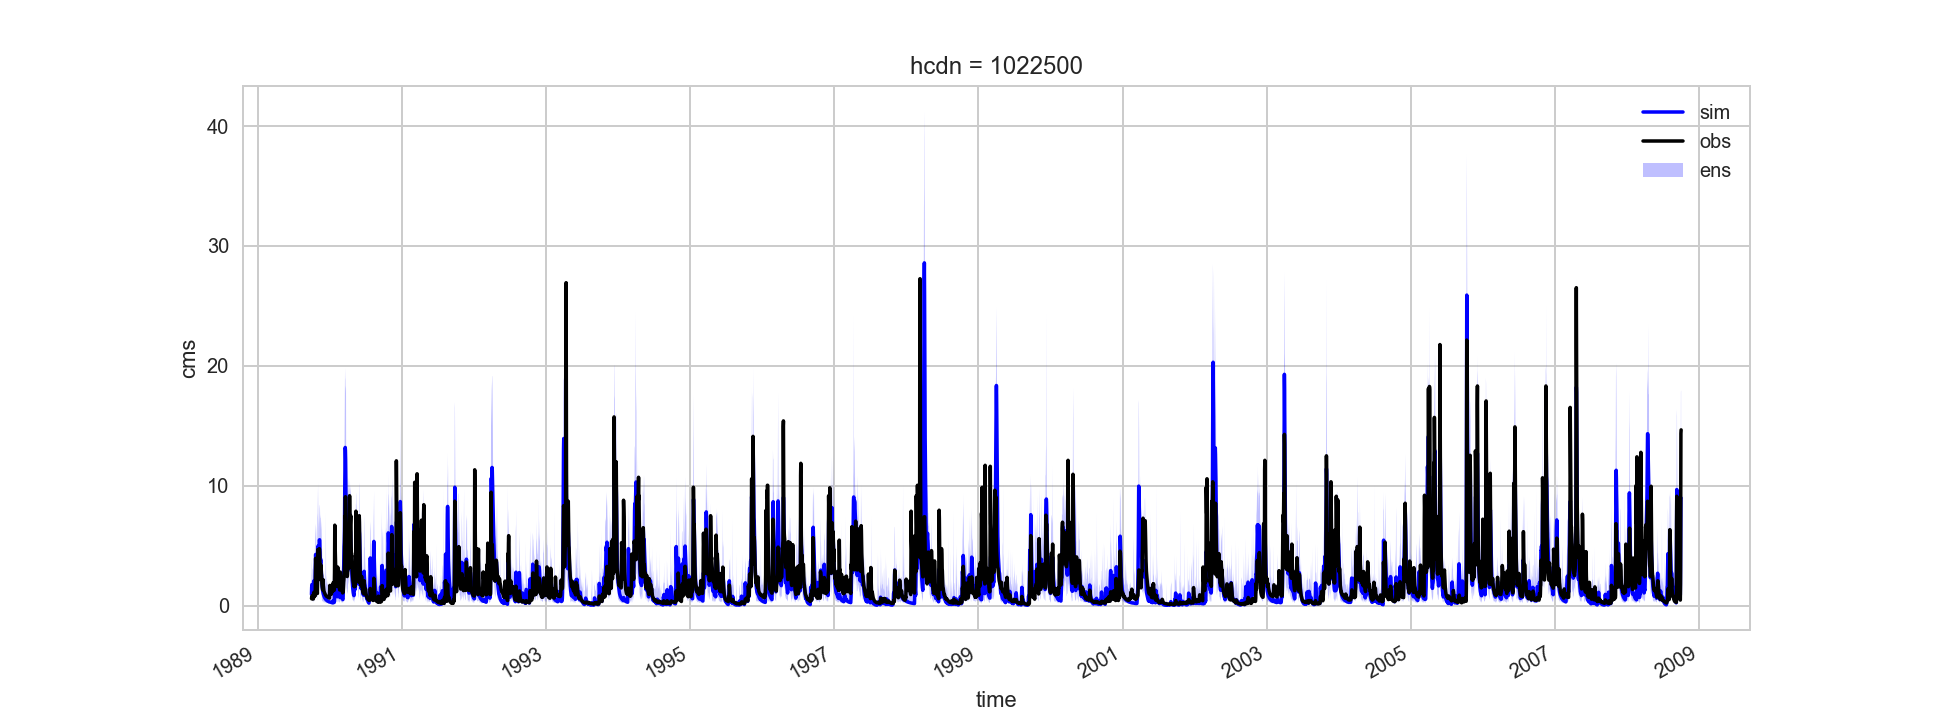

Text(0,0.5,'cms')

In [22]:
# plot 5-95% range of residual added flows
sim_ens = ds_vic_flow_ens_all['kge_ens'].sel(hcdn=hcdn)
sim = ds_vic_flow_all['kge'].sel(hcdn=hcdn)
obs = ds_vic_flow_all['obs'].sel(hcdn=hcdn)
sim_ens_med = sim_ens.median(dim='ens')
sim_ens_5 = sim_ens.quantile(0.05, dim='ens')
sim_ens_95 = sim_ens.quantile(0.95, dim='ens')

print(sim_ens_5.values)

_, ax1 = plt.subplots(figsize=(13.5, 5))

ax1.fill_between(sim_ens_95['time'].values, sim_ens_95.values, sim_ens_5.values, facecolor='blue', alpha=0.25, label='ens')
sim.plot(ax=ax1, color='blue', label='sim')
obs.plot(ax=ax1, color='black',label='obs')
ax1.legend()
ax1.set_ylabel('cms')
#ax1.set_ylim(0, 10)

In [23]:
#test with numpy (xarry is slow...)
sim_ens_all = ds_vic_flow_ens_all['kge_ens']
sim_ens_95 = np.percentile(sim_ens_all.values, 0.95, axis=2)

<IPython.core.display.Javascript object>


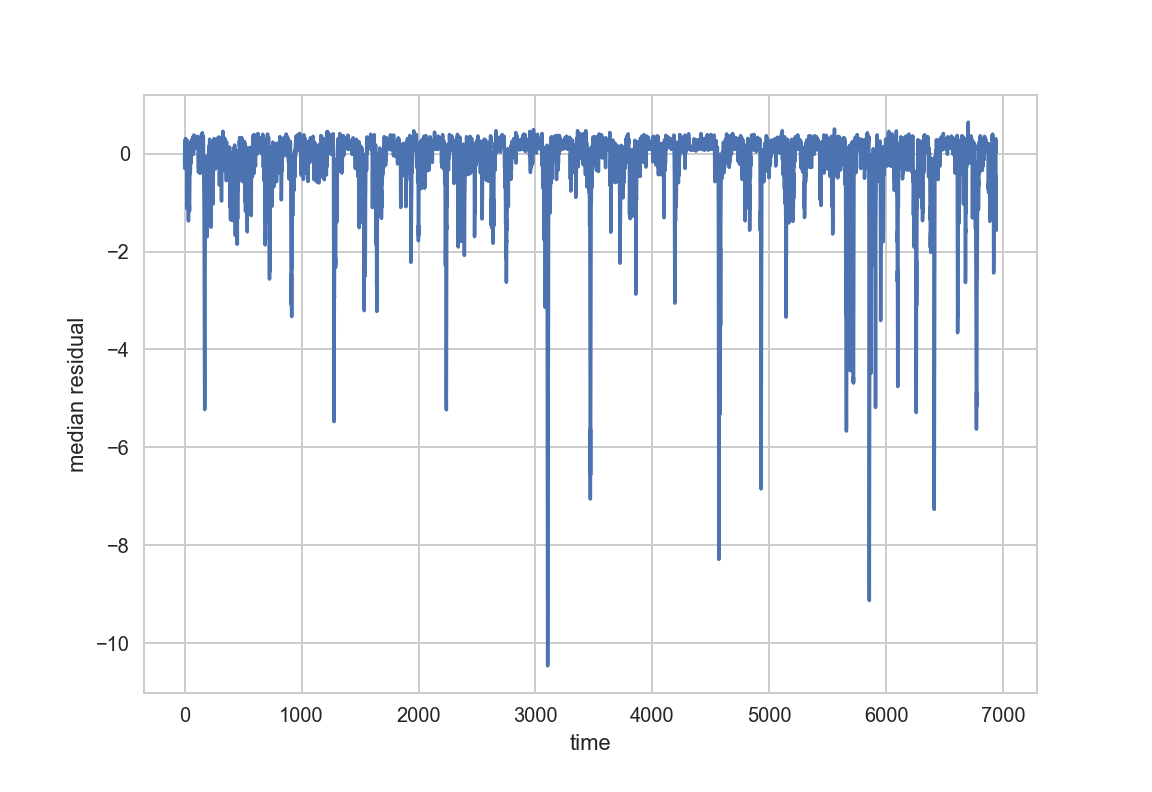

Mean
obs, sim, residual
2.070870 2.020573 -0.168233

variance
obs, sim, residual, 2 x covariance between sim and res
5.911065 6.363394 0.631290 -3.725207
obs, sim+res
5.911065 = 3.269477

covariance
5.911065 4.735085 -1.313500 


In [15]:
# statistical moment on median residual 
sim_ens = ds_vic_flow_ens_all['kge_ens'].sel(hcdn=hcdn)
sim_ens_med = sim_ens.median(dim='ens')
sim = ds_vic_flow_all['kge'].sel(hcdn=hcdn)
obs = ds_vic_flow_all['obs'].sel(hcdn=hcdn)

res_ens_med = sim_ens_med - sim

#plot
plt.plot(res_ens_med)
plt.xlabel('time');plt.ylabel('median residual')

# Mean
obs_mean = obs.mean()
sim_mean = sim.mean()
res_mean = res_ens_med.mean()
print('Mean')
print('obs, sim, residual')
print('%f %f %f'%(obs_mean, sim_mean, res_mean))
 
# Variance
obs_var = obs.var()
sim_var = sim.var()
res_var = res_ens_med.var()
sim_res_cov = np.cov(sim.values, res_ens_med.values)[0][1]
print('\nvariance')
print('obs, sim, residual, 2 x covariance between sim and res')
print('%f %f %f %f'%(obs_var, sim_var, res_var, 2*sim_res_cov))
print('obs, sim+res')
print('%f = %f'%(obs_var, sim_var+res_var+2*sim_res_cov))

# Covariance
obs_sim_cov = np.cov(obs.values, sim.values)[0][1]
obs_res_cov = np.cov(obs.values, res_ens_med.values)[0][1]
print('\ncovariance')
print('%f %f %f '%(obs_var, obs_sim_cov, obs_res_cov))

In [19]:
# residual and statistical moment
ens = ds_vic_flow_ens_all['ens']
ntime = len(ds_vic_flow_ens_all['time'])
for hcdn in df_hcdn['id']:
    
    sim_ens = ds_vic_flow_ens_all['kge_ens'].sel(hcdn=hcdn)
    sim = ds_vic_flow_all['kge'].sel(hcdn=hcdn)
    obs = ds_vic_flow_all['obs'].sel(hcdn=hcdn)
    
    #compute residual at once sim_ens[time, ens]    
    sim2,_ = xr.broadcast(sim, ens)  
    res_ens = sim_ens - sim2

    # Mean, obs:[1], sim_mean:[1,ens], res_mean:[1,ens]
    obs_mean = obs.mean()
    sim_mean = sim.mean()
    res_mean = res_ens.mean(dim='time')  
    
    # Variance, obs:[1], sim_mean:[1,ens], res_mean:[1,ens]
    obs_var = obs.var()
    sim_var = sim.var()
    res_var = res_ens.var(dim='time')    
    
    #Covariance between sim and res
    res_mean2,_ = xr.broadcast(res_mean, ens)
    sim_res_cov = xr.dot(sim2-sim_mean, res_ens-res_mean2, dims=['time'])/(ntime-1)
    
    sim_res_var = sim_var+res_var+2*sim_res_cov
    
#    print('%d: %f = %f %f %f'%(hcdn, obs_var, sim_var, res_var, 2*sim_res_cov))
    print('%d: %f = %f '%(hcdn, obs_var, sim_res_var.median()))    

1022500: 5.911065 = 6.186655 
1031500: 10.706697 = 10.844424 
1047000: 11.178922 = 35127.665143 
1052500: 14.333796 = 13.922934 
1055000: 16.584469 = 16.398251 
1057000: 8.024168 = 58.028800 
1073000: 8.336588 = 7.520963 
1078000: 6.660254 = 12.346526 
1123000: 4.948080 = 4.941626 
1137500: 10.430667 = 10.695711 
1139000: 3.596968 = 3.790372 
1139800: 3.618963 = 3.626614 
1142500: 5.064629 = 193.976001 
1144000: 5.373128 = 5.725999 
1162500: 5.323779 = 5.582339 
1169000: 11.196732 = 11.058080 
1170100: 8.606434 = 8.714611 
1181000: 11.829741 = 10.810555 
1187300: 13.411160 = 12.593235 
1195100: 6.070815 = 6.287342 
1333000: 6.018998 = 6.141892 
1350000: 14.630478 = 13.861799 
1350080: 6.514124 = 6.609327 
1365000: 13.279016 = 13.033169 
1411300: 1.227931 = 1.249825 
1413500: 8.150897 = 8.410180 
1414500: 9.870657 = 10.066815 
1415000: 6.645669 = 6.914670 
1423000: 7.269795 = 6.857929 
1434025: 20.913105 = 18.671331 
1435000: 19.439152 = 18.796779 
1439500: 5.726747 = 5.688332 
1440000:

In [17]:
 # correlation check
ens = ds_vic_flow_ens_all['ens']
ntime = len(ds_vic_flow_ens_all['time'])
for hcdn in df_hcdn['id']:
    sim_ens = ds_vic_flow_ens_all['kge_ens'].sel(hcdn=hcdn)
    sim = ds_vic_flow_all['kge'].sel(hcdn=hcdn)
    obs = ds_vic_flow_all['obs'].sel(hcdn=hcdn)
    
    #compute residual at once sim_ens[time, ens]    
    sim2,_ = xr.broadcast(sim, ens)  
    res_ens = sim_ens - sim2

    # Mean, obs:[1], sim_mean:[1,ens], res_mean:[1,ens]
    obs_mean = obs.mean()
    sim_mean = sim.mean()
    res_ens_mean = res_ens.mean(dim='time')  
    
    # Variance, obs:[1], sim_mean:[1,ens], res_mean:[1,ens]
    obs_std = np.sqrt(obs.var())
    sim_std = np.sqrt(sim.var())
    res_ens_std = np.sqrt(res_ens.var(dim='time'))
    sim_ens_std = np.sqrt(sim_ens.var(dim='time'))
    
    obs2,_ = xr.broadcast(obs, ens)
    res_mean2,_ = xr.broadcast(res_mean, ens)
    obs_res_cor = xr.dot(obs2-obs_mean, res_ens-res_mean2, dims=['time'])/(ntime-1)/obs_std/res_ens_std
    obs_sim_cor = xr.dot(obs-obs_mean, sim-sim_mean, dims=['time'])/(ntime-1)/obs_std/sim_std
    
    lft_array = obs_sim_cor*sim_std + obs_res_cor*res_ens_std
    rgt_array = obs_sim_cor*sim_ens_std
 
    print('%d: %f vs %f '%(hcdn, np.median(lft_array),  np.median(rgt_array))) 

1022500: 1.543053 vs 1.920408 
1031500: 1.849512 vs 2.450676 
1047000: 0.615512 vs 145.776065 
1052500: 2.493661 vs 3.033151 
1055000: 2.333880 vs 3.050120 
1057000: 1.749534 vs 6.015664 
1073000: 1.977075 vs 2.325451 
1078000: 1.560679 vs 2.759005 
1123000: 1.467748 vs 1.800085 
1137500: 1.848871 vs 2.460667 
1139000: 1.285344 vs 1.558427 
1139800: 1.251048 vs 1.533185 
1142500: 1.311963 vs 10.997571 
1144000: 1.545465 vs 1.892047 
1162500: 1.247003 vs 1.655312 
1169000: 1.405144 vs 2.131582 
1170100: 1.351861 vs 1.932965 
1181000: 1.366781 vs 2.091864 
1187300: 1.630825 vs 2.394062 
1195100: 1.588305 vs 1.983339 
1333000: 1.171425 vs 1.675932 
1350000: 1.953549 vs 2.711780 
1350080: 1.365475 vs 1.862110 
1365000: 2.239096 vs 2.830332 
1411300: 0.840232 vs 0.960251 
1413500: 1.515993 vs 2.060452 
1414500: 1.429087 vs 2.075789 
1415000: 1.362039 vs 1.886044 
1423000: 1.401410 vs 1.903561 
1434025: 2.381635 vs 3.196244 
1435000: 2.519207 vs 3.258156 
1439500: 1.533908 vs 1.891744 
14400

In [ ]:
# generate model residuals stochastically
#Farmer and Vogel
def FV2016(sim, obs, nens):
    # sim:  1 dimension numpy array
    # obs:  1 dimension numpy array
    sim = np.where(sim>0.0, sim, 1.0e-7)
    obs = np.where(obs>0.0, obs, 1.0e-7)
    
    # compute ranked simulation (i.e., descending order) and nonexceedance probablity with weibull plotting position
    sim_ordered = np.sort(sim)
    index_ordered = np.argsort(sim)
    prob = np.arange(1,float(len(sim)+1))/(1+len(sim)) #probability
   
    # residual - ratio of sim to obs
    res = obs/sim
    res_ordered = res[index_ordered]

    # group simulation and residual into 10 groups defined by 10 equal nonexceedance probability range
    # 0: [0.0 0.1]
    # 1: [0.1 0.2]
    # .
    # .
    # 9: [0.9 1.0]
    # -----
    # grouping residual
    prange = np.arange(0.,1.01,0.01)
    res_grouped = {}
    sim_grouped = {}
    for idx in range(len(prange)-1):
        res_grouped[idx] = res_ordered[(prob >= prange[idx]) & (prob < prange[idx+1])]
        sim_grouped[idx] = sim_ordered[(prob >= prange[idx]) & (prob < prange[idx+1])]

    # make time series of group based on sim and probability
    cat = np.full(len(sim),-999, np.dtype('int32'))
    for idx, idx_ord in enumerate(index_ordered):
        cat[idx_ord] = int(np.floor(prob[idx]*100))

    # For each flow in each group, synthetic flow is generated 
    # by randomely selecting residual from the associated group
    q1 = np.full((len(sim),nens), -999.0)
    for iens in range(nens):
        for idx, q in enumerate(sim):
            res_one_group = res_grouped[cat[idx]]
            res_sampled = np.random.choice(res_one_group,1)
            q1[idx, iens] = q*res_sampled
            
    return q1